# Milestone Project 04
### Selecting and Testing Multiple Classification Models on Text Data
In the previous 3 milestone projects and the lesson 9 assignment on naive bayes models I have used a dataset of sentences extracted from various articles and books in an attempt to extract unique grammatical features and use those features to label the quality of the sentences as good or bad. This work is relevant to me as an important preparation phase in training models to make sense and comprehend text. We want to choose the best sentences to teach the machines just like a chef would choose the best ingredients to prepare a meal.

### Goal of the project
- We will prepare the dataset and use it to train and compare 3 different classification models
- We will make recommendations on how to improve the model accuracies if needed
- We will define a null and alt hypothesis and test them

### Load the dataset

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
# Make dataframes more print friendly
pd.set_option('display.notebook_repr_html', True)
def _repr_latex_(self):  return f'\centering{self.to_latex()}'
pd.DataFrame._repr_latex_ = _repr_latex_

In [3]:
# Dataset location
fileName = "https://raw.githubusercontent.com/kazarazat/datasetify/master/csvs/summary-nlp-data.csv"

### Summary Statistics

In [4]:
# Create a dataFrame from the CSV
df = pd.read_csv(fileName)

In [5]:
# Make sure that the column we need to use as the label is the first column
cols = ['Label','Word Count','Noun Count','Verb Count','Diversity','SVO Chance']
df = df[cols]

In [6]:
df.head()

,Label,Word Count,Noun Count,Verb Count,Diversity,SVO Chance
0,good,high,high,low,low,high
1,good,high,high,high,low,high
2,good,high,high,high,low,low
3,bad,low,low,low,high,low
4,good,high,high,high,low,high


In [7]:
# Summary
np.round(df.describe(), 2).T

,count,unique,top,freq
Label,7044,2,good,5264
Word Count,7044,2,high,5062
Noun Count,7044,2,high,5194
Verb Count,7044,2,low,3910
Diversity,7044,2,high,3659
SVO Chance,7044,2,high,5625


### Observations on the dataset
- There are 5 unique feature columns
- The features are as independant as we can expect for linguistic characteristics
- The categorical values of the features are high and low
- A heuristic based on the feature values was used to determine the label
- 7044 english sentences were processed to create the dataset

### Import the Scikit Learn models

In [8]:
import sklearn.naive_bayes
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, confusion_matrix, auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

### Create the feature vectors
Machine learning models only accept numerical inputs so we will convert our categorical features into vectors

In [9]:
# A method that takes the dataframe and target column as input and returns the feature vectors
def get_feature_vecs(dat,target_col):
    label_col = target_col
    values = ['high', 'low']
    for c in dat.columns[1:]:
        dat[c] = dat[c].astype('object').astype(
            pd.api.types.CategoricalDtype(categories=values))
    features = np.array([dat[c].cat.codes for c in dat.columns if c != label_col]).T
    return features

In [10]:
feature_vecs = get_feature_vecs(df,'Label')
# Check the shape of the feature vectors
feature_vecs.shape

(7044, 5)

We check the shape of the feature vectors to make sure that the target column was removed and that nothing else changed in the process of vectorizing the categorical values

### Create the target values
Machine learning models only accept numerical inputs so we will convert our target values from string to 0s and 1s to represent class 0 and class 1 for the model to predict.

In [11]:
# A method to convert the target categories into ints (0,1)
def get_target(dat,target_col):
    dat[target_col] = dat[target_col].astype('object').astype(pd.api.types.CategoricalDtype(
                   categories=['good','bad']))
    # Convert our labeled data to numeric values
    labels = dat[target_col].cat.codes
    # take a look at the mapping for the first 5 values 
    print ("First 5 values of the target:",list(zip(dat[target_col][:5], labels[:5])))
    return labels

In [12]:
labels = get_target(df,'Label')

First 5 values of the target: [('good', 0), ('good', 0), ('good', 0), ('bad', 1), ('good', 0)]


The target set will not include the previous string category values but we want to double check that class 0 is mapped to 'good' and class 1 is mapped to 'bad' before we proceed.

### Create a Holdout set
- We will split our dataset for training and testing. We can best measure accuracy on the testing set
- We will holdout 30% of the dataset for testing


In [13]:
X_train, X_test, y_train, y_test = train_test_split(feature_vecs,
                                                    labels,
                                                    test_size=.30,
                                                    random_state=42)

### Visualizing the model statistics
This method encapsulates the **Accuracy**, **F1 Score**, **Precision** and **Recall** as well as the visualizations of the **Confusion Matrix**, **Prediction Distribution** (TP, FP overlap) and the **ROC curve**. Abstracting this to a method makes it easier to see the important statics and visualizations of the different models we will be testing.

In [14]:
# Some of this code was referenced from a blog post on Towards Data Science
def evalBinaryClassifier(model, x, y, labels=['Positives','Negatives']):
    #model predicts probabilities of positive class
    p = model.predict_proba(x)
    if len(model.classes_)!=2:
        raise ValueError('A binary class problem is required')
    if model.classes_[1] == 1:
        pos_p = p[:,1]
    elif model.classes_[0] == 1:
        pos_p = p[:,0]
    
    #FIGURE
    plt.figure(figsize=[15,4])
    
    #1 -- Confusion matrix
    cm = confusion_matrix(y,model.predict(x))
    plt.subplot(131)
    ax = sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, 
                annot_kws={"size": 14}, fmt='g')
    cmlabels = ['True Negatives', 'False Positives',
              'False Negatives', 'True Positives']
    for i,t in enumerate(ax.texts):
        t.set_text(t.get_text() + "\n" + cmlabels[i])
    plt.title('Confusion Matrix', size=15)
    plt.xlabel('Predicted Values', size=13)
    plt.ylabel('True Values', size=13)
      
    #2 -- Distributions of Predicted Probabilities of both classes
    df = pd.DataFrame({'probPos':pos_p, 'target': y})
    plt.subplot(132)
    plt.hist(df[df.target==1].probPos, density=True, bins=25,
             alpha=.5, color='green',  label=labels[0])
    plt.hist(df[df.target==0].probPos, density=True, bins=25,
             alpha=.5, color='red', label=labels[1])
    plt.axvline(.5, color='blue', linestyle='--', label='Boundary')
    plt.xlim([0,1])
    plt.title('Distributions of Predictions', size=15)
    plt.xlabel('Positive Probability (predicted)', size=13)
    plt.ylabel('Samples (normalized scale)', size=13)
    plt.legend(loc="upper right")
    
    #3 -- ROC curve with annotated decision point
    fp_rates, tp_rates, _ = roc_curve(y,p[:,1])
    roc_auc = auc(fp_rates, tp_rates)
    plt.subplot(133)
    plt.plot(fp_rates, tp_rates, color='green',
             lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], lw=1, linestyle='--', color='grey')
    #plot current decision point:
    tn, fp, fn, tp = [i for i in cm.ravel()]
    plt.plot(fp/(fp+tn), tp/(tp+fn), 'bo', markersize=8, label='Decision Point')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', size=13)
    plt.ylabel('True Positive Rate', size=13)
    plt.title('ROC Curve', size=15)
    plt.legend(loc="lower right")
    plt.subplots_adjust(wspace=.3)
    plt.show()
    #Print and Return the F1 score
    tn, fp, fn, tp = [i for i in cm.ravel()]
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    F1 = 2*(precision * recall) / (precision + recall)
    # Get the model accuracy
    test_probs = p
    test_results = np.argmax(test_probs, axis=1)
    test_logical_correct = [pred == actual for pred, actual in zip(test_results, y)]
    test_acc = np.mean(test_logical_correct)
    print('Model accuracy: {}'.format(np.round(test_acc,2)))
    print("="*77)
    
    printout = (
        f'Precision (Class 0): {round(precision,2)} | '
        f'Recall (Class 0): {round(recall,2)} | '
        f'F1 Score (Class 0): {round(F1,2)} | '
    )
    print(printout)
    return F1

### Classifying with Naive Bayes
Naive Bayes is the perfect model for classifications where the datasets are not too large and the features are independant because it assumes independance. 

In [15]:
# Define the Naive Bayes model
nb_model = sklearn.naive_bayes.MultinomialNB(alpha=3)
# Fit the model with the split of the dataset for training
nb_model.fit(X_train, y_train)

MultinomialNB(alpha=3)

### Evaluate Naive Bayes
We will use our evaluation method to visualize the performance of the Naive Bayes model using the holdout set

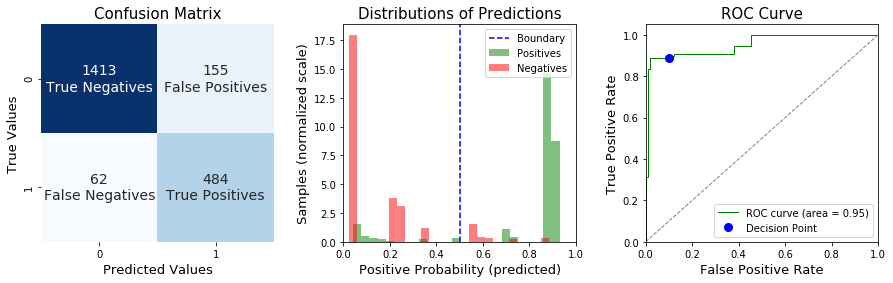

Model accuracy: 0.9
Precision (Class 0): 0.76 | Recall (Class 0): 0.89 | F1 Score (Class 0): 0.82 | 


In [16]:
eval_nb = evalBinaryClassifier(nb_model,X_test,y_test)

### Observations on Naive Bayes Model Statistics
- The dataset is extremely well fit to the model
- The model accuracy may be improved by increasing the amount of True Negatives
- The model achieved the maximum number of True Positives at the default threshold of 0.5
- There is no overlap between the predicted True Positives and False Positives

### Classifying with Logistic Regression
Logistic regression models have binary outputs which makes them ideal for binary classification jobs like this one. Unlike a linear regression the predication probabilities are plotted along a sigmoid curve instead of a straight line. This represents a linear classification between class 0 and class 1

In [17]:
# Define the Logistic Regression model
lr_model = LogisticRegression()
# Fit the model with the split of the dataset for training
lr_model.fit(X_train, y_train)

LogisticRegression()

### Evaluate Logistic Regression
We will use our evaluation method to visualize the performance of the Logistic Regression model using the holdout set

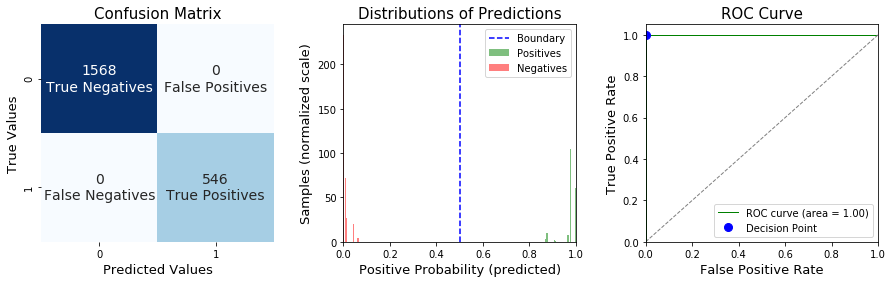

Model accuracy: 1.0
Precision (Class 0): 1.0 | Recall (Class 0): 1.0 | F1 Score (Class 0): 1.0 | 


In [18]:
eval_lr = evalBinaryClassifier(lr_model,X_test,y_test)

### Observations on Logistic Regression Model Statistics
- The logistic regression performed better than the naive bayes on the dataset
- The model may have performed better because it is less biased by feature independance than Naive bayes
- The model may have performed so well because there is a significant imbalance between class 0 and 1

### Classifying with K Nearest Neighbor
K Nearest Neighbor can be used for classification tasks because it plots target and feature vectors then uses a distancing formula, usually Euclidean to predict class. KNN works well with normalized data from range 0 to 1 and datasets that are not too large because of the sensitivity of the Euclidean distance.  

In [19]:
# Define the K Nearest Neighbor using 3 as the  model
knn_model = KNeighborsClassifier(n_neighbors=3)
# Fit the model with the split of the dataset for training
knn_model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

We set 3 as the value for the number of neighbors to start. We could evaluate and increase the number to see how it changes the results. We could also use an elbow curve to evaluate the data and get an estimate of the best value of K to use.

### Evaluate K Nearest Neighbor
We will use our evaluation method to visualize the performance of the K Nearest neighbor model using the holdout set

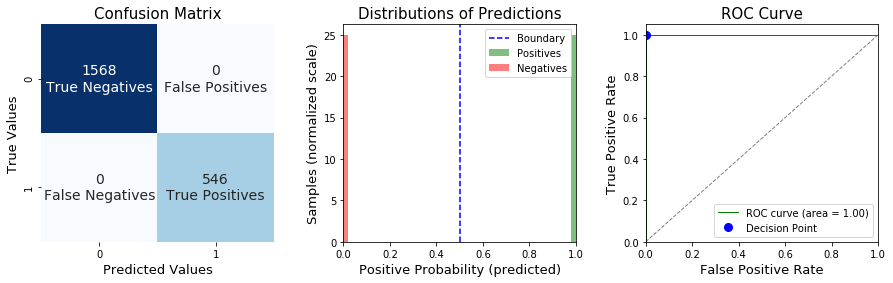

Model accuracy: 1.0
Precision (Class 0): 1.0 | Recall (Class 0): 1.0 | F1 Score (Class 0): 1.0 | 


In [20]:
eval_knn = evalBinaryClassifier(knn_model,X_test,y_test)

### Observations on KNN Model Statistics
- The k nearest neighbor performed as well as logistic regression and better than the naive bayes
- Unlike the previous two models that use probability, KNN is using Euclidean distance to determine class
- Like logistic regression the results may be a result of imbalanced data

### Hypothesis Testing
We saw perfect accuracy scores from 2 of our 3 models and a score of 90% on the third model. We could accept these results or subject them to further testing. 

#### Alt hypothesis
Is it possible that the imbalance of **good** and **bad** class values in our target set could be causing the exceptional accuracy of predictions in our models? If we balance the target class we will see a statistically significant change in the accuracy of at least one of the models

#### Null hypothesis
There will not be a statistically significant change in model accuracy after we test with a dataset that is balanced between class 0 and class 1 within the target set. We will consider statistical significance to be a **+/- 1%** change in the accuracy score for every **10% change** to the class count ratio

### Visualize the distribution of Class 0 and Class 1 in the Features
Explore the data by looking at the first 5 rows to get an idea of the counts of high and low categorical values across the 5 feature columns

In [21]:
# Define a method to plot the distributions of the target class across the features
def bar_plot_distributions():
    df['Label'] = df['Label'].astype('object').astype(pd.api.types.CategoricalDtype(
                       categories=['good','bad']))
    values = ['low','high']
    for c in df.columns[1:]:
        df[c] = df[c].astype('object').astype(
            pd.api.types.CategoricalDtype(categories=values))
    good_sents = df[df['Label'] == 'good']
    bad_sents = df[df['Label'] == 'bad']
    for df_col in df.columns[1:6]:
        plt.subplot(1, 2, 1)
        plt.hist([1 if x == 'high' else 0 for x in good_sents[df_col]])
        plt.title('Good: \n' + df_col)
        plt.ylabel('count')
        plt.subplot(1, 2, 2)
        plt.hist([1 if x == 'high' else 0 for x in bad_sents[df_col]])
        plt.title('Bad: \n' + df_col)
        plt.show()

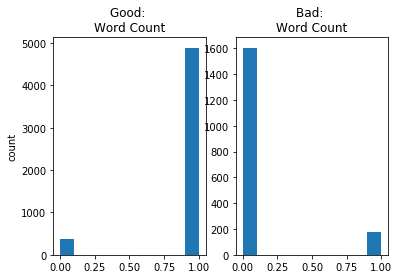

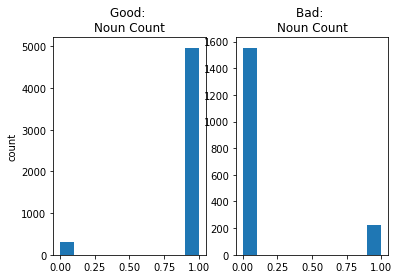

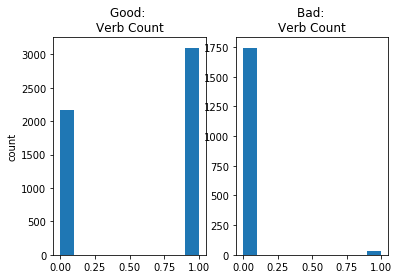

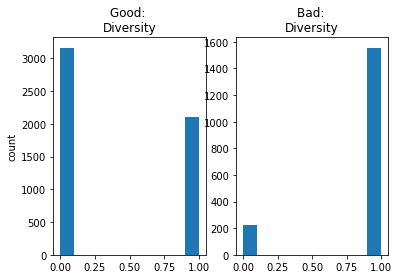

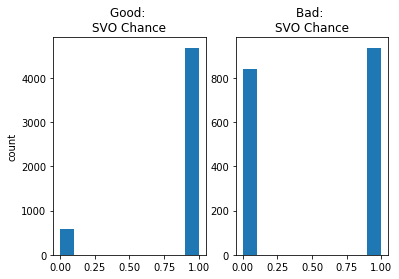

In [22]:
bar_plot_distributions()

### Observations
The visualizations confirm that across most of the features there is an imbalance between **good** and **bad** classes of the target data. We can't determine yet if or how this has impacted the performance of our models.

### Visualize the distribution of Class 0 and 1 in the Target Set

In [23]:
# A method to plot class ratio with PCA decomposition
def plot_class_ratio(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

Class 0 (Good): 5264
Class 1 (Bad): 1780
Proportion: 2.96 : 1


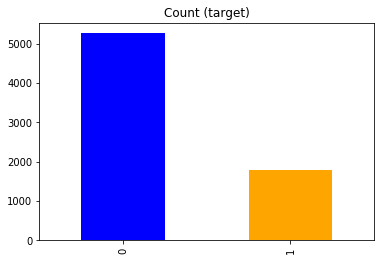

In [24]:
target_count = labels.value_counts()
print('Class 0 (Good):', target_count[0])
print('Class 1 (Bad):', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')
target_count.plot(kind='bar', color=['blue','orange'],title='Count (target)');

### Observations
- The visualization doesn't show an unreasonable amount of class count imbalance given the expected real world ratio of good to bad sentences in a particular piece of English text.
- This visualization by itself isn't enough to accept or reject the null hypothesis but does show further evidence that there could be imbalance with class 0 and 1 

### Visualize Class Imbalance with PCA
We will use PCA to decompose the dimensionality of the feature set so that we can use a different 2D visualization method to try to determine if there is imbalance and how bad it might be.

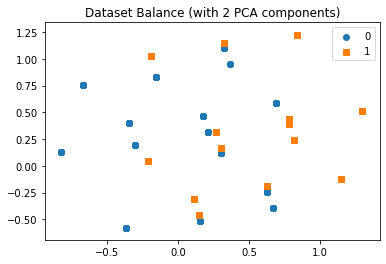

In [25]:
pca = PCA(n_components=2)
X = pca.fit_transform(feature_vecs)
plot_class_ratio(X, labels, 'Dataset Balance (with 2 PCA components)')

### Observations
- This visualization appears to align with the **~3:1** ratio of class 0 to class 1
- Again based on knowledge of the nature of sentences written by english writers the class imbalance doesn't appear extreme

### Create an Under Sample of Class 0
To determine whether to reject of accept our null hypothesis we will create a new feature and target set where class 0 is under sampled and then evaluate the performance of our models trained on that set.

In [26]:
# Class counts
count_class_0, count_class_1 = df.Label.value_counts()

# Divide the data by class taking only 3000 of class 0
df_class_0 = df[df['Label'] == 'good'][:3000]
df_class_1 = df[df['Label'] == 'bad']

# Apply the over sample to class 1
#class_1_over = df_class_1.sample(count_class_0,replace=True)
oversample_df = pd.concat([df_class_0,df_class_1], axis=0)

### Visualize the Class distribution of the Under Sampled Dataset

Class 0 (Good): 3000
Class 1 (Bad): 1780
New Proportion: 1.69 : 1


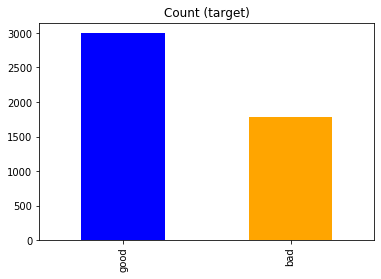

In [27]:
null_target_count = oversample_df.Label.value_counts()
print('Class 0 (Good):', null_target_count[0])
print('Class 1 (Bad):', null_target_count[1])
print('New Proportion:', round(null_target_count[0] / null_target_count[1], 2), ': 1')
null_target_count.plot(kind='bar', color=['blue','orange'],title='Count (target)');

### Observations
- Class 0 only has a value count of 3000 versus 5264 in the original target set
- Class 1 has not changed with a value count of 1780
- The new proportion of class 0 to class 1 is 1.69 ( more than half the original proportion )

### Prepping the Over Sampled Dataset

In [28]:
# Check the shape of the Under Sampled data
oversample_df.head()

,Label,Word Count,Noun Count,Verb Count,Diversity,SVO Chance
0,good,high,high,low,low,high
1,good,high,high,high,low,high
2,good,high,high,high,low,low
4,good,high,high,high,low,high
5,good,high,high,low,high,high


The head of this dataframe looks the same as our original. We should randomly sample the Over Sampled dataset by the shape of the y axis of the original dataset.

In [29]:
null_test_df = oversample_df

### Create the vector set and target set from the Under Sampled data

In [30]:
null_labels = get_target(null_test_df,'Label')
null_feature_vecs = get_feature_vecs(null_test_df,'Label')

First 5 values of the target: [('good', 0), ('good', 0), ('good', 0), ('good', 0), ('good', 0)]


### Create a holdout set for the Under Sampled dataset

In [31]:
null_X_train, null_X_test, null_y_train, null_y_test = train_test_split(null_feature_vecs,
                                                    null_labels,
                                                    test_size=.30,
                                                    random_state=42)

### Selecting a model for the hypothesis testing
Since the Naive Bayes model at 90% performed worst among the 3 models we will use that model to evaluate our over sampled dataset. Because of the assumption of independance for NB models it's possible that some bias was introduced and that makes this model the more sensitive of the 3 we're testing. 

In [32]:
# Define the Naive Bayes model
null_nb_model = sklearn.naive_bayes.MultinomialNB(alpha=3)
# Fit the model with the split of the dataset for training
null_nb_model.fit(null_X_train, null_y_train)

MultinomialNB(alpha=3)

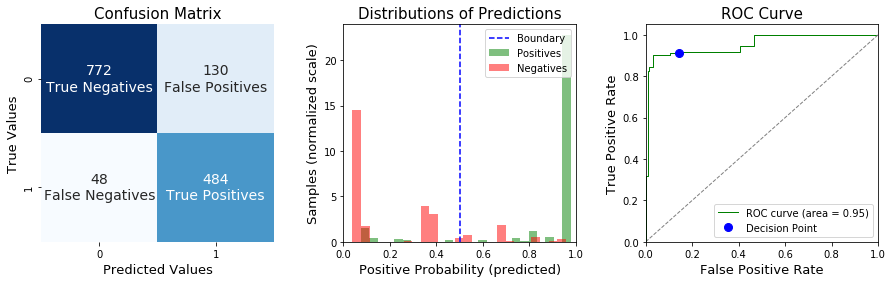

Model accuracy: 0.88
Precision (Class 0): 0.79 | Recall (Class 0): 0.91 | F1 Score (Class 0): 0.84 | 


In [33]:
eval_null_nb = evalBinaryClassifier(null_nb_model,null_X_test,null_y_test)

## Conclusion
We will accept the null hypothesis that the presence of imbalance between the classes of the target set have statistically insignificant impact of the accuracy of the classification models for the following reasons:

In [34]:
ratio_change = np.round(100*(1.69/2.96),2)
accuracy_change = np.round(.9/.88,2)
acceptance = np.round(ratio_change/10)
print ("The under sampled dataset reduced the class 0 to class 1 count ratio by {}%".format(ratio_change))
print ("This resulted in a {}% change to the accuracy score on the Naive Bayes model".format(accuracy_change))
print ("It's possible that the difference in data size could account for the accuracy change as well")
print ("To accept the alt hypothesis the accuracy change would need to be +/- {}%".format(acceptance))

The under sampled dataset reduced the class 0 to class 1 count ratio by 57.09%
This resulted in a 1.02% change to the accuracy score on the Naive Bayes model
It's possible that the difference in data size could account for the accuracy change as well
To accept the alt hypothesis the accuracy change would need to be +/- 6.0%


### Null Hypothesis accepted: Yes
Based on the acceptance criteria we **accept** the null hypothesis with no error

# What improved from previous Milestones
- Model accuracy for Naive Bayes improved from .85 to .9
- We added more features to the dataset and insured that there was greater independance
- Previously we attempted to predict sentence typology however that is now an additional feature
- The size of the dataset was increased with more observations than the previous milestones
- We used a holdout set to test the accuracy of the models
- We used a target with class values derived from conditional logic of the feature values
- We established an alt and null hypothesis on the impact of target class imbalance on the model accuracy
- We set and acceptance / rejection criteria for the null hypothesis
- We analyzed the effect of an under sampled target dataset on the models
- We produced and visualized better model performance statistics than previous milestones